# Expana -- assignment interview

## Create a presentation where you describe the characteristics of this time series and explain how you expect it to evolve until the end of 2023.

### 1. Loading the libraries and the data

In [1]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import TimeSeriesSplit



color_pale = sns.color_palette()
plt.style.use('seaborn-v0_8')

<Axes: title={'center': 'Exapana time series'}, xlabel='Date'>

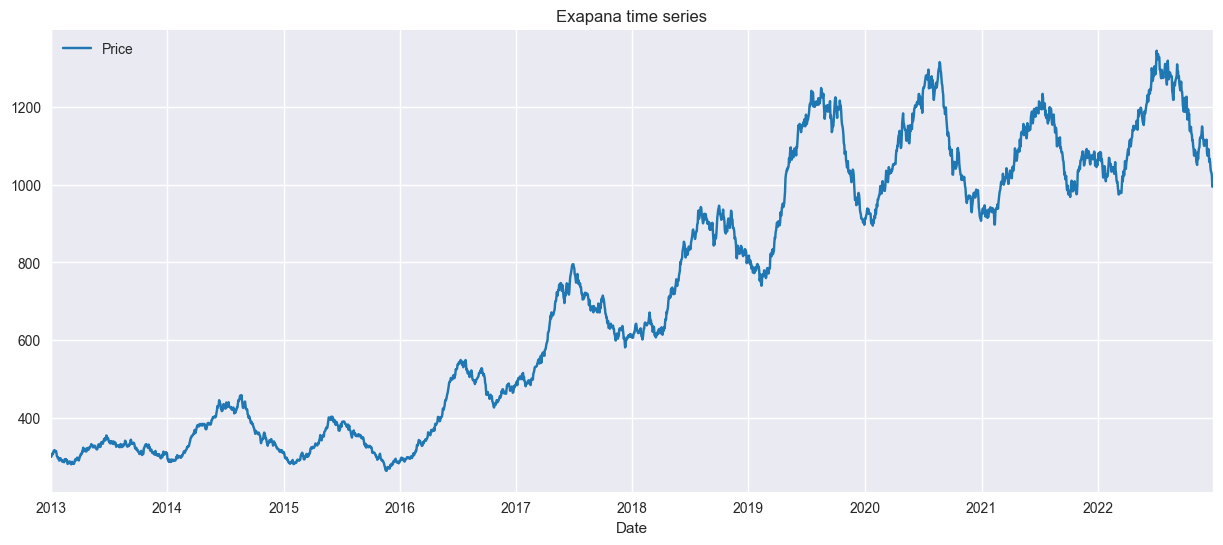

In [2]:
df = pd.read_excel("quantitative_analyst_case_Feb_2025.xlsx")
# date format: timstamp YYYY-mm-dd
df = df.set_index("Date")
df.plot(figsize=(15, 6), color = color_pale[0], title= "Exapana time series")

In [3]:
#checking the starting date and end date
df.index.min(), df.index.max()

(Timestamp('2012-12-31 00:00:00'), Timestamp('2022-12-30 00:00:00'))

### 1.1 Time series components
We know that time series is a combination of (maunly) three components:
- Trend: overall development of the series. It can consistently increase or decrease over time or a combination of both
- Seasonality: any seasonal pattern during the series
- Residuals whih have been always thought as statistical noise (random irregularity present in real-life data)

In [4]:
df = df.resample(rule = 'd').mean().ffill().asfreq('D')

<Figure size 1500x1000 with 0 Axes>

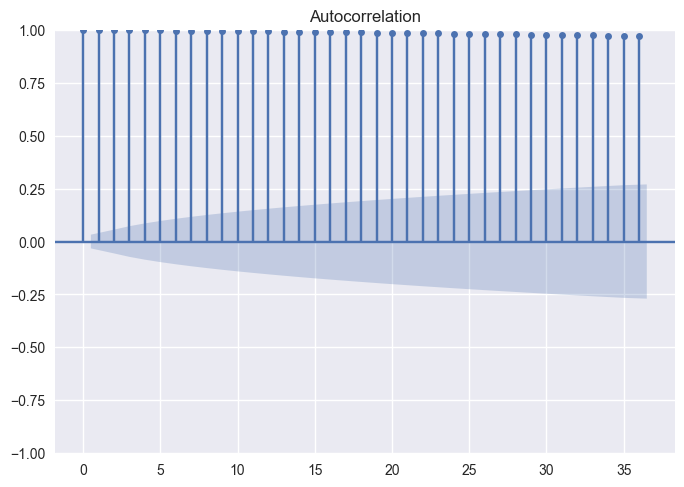

In [5]:
# ACF plot
plt.figure(figsize=(15, 10))

plot_acf(df['Price'])
plt.show()

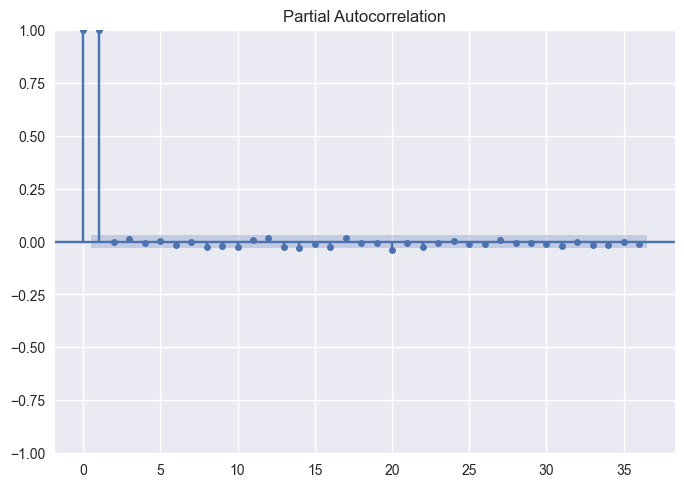

In [6]:
plot_pacf(df['Price'])
plt.show()

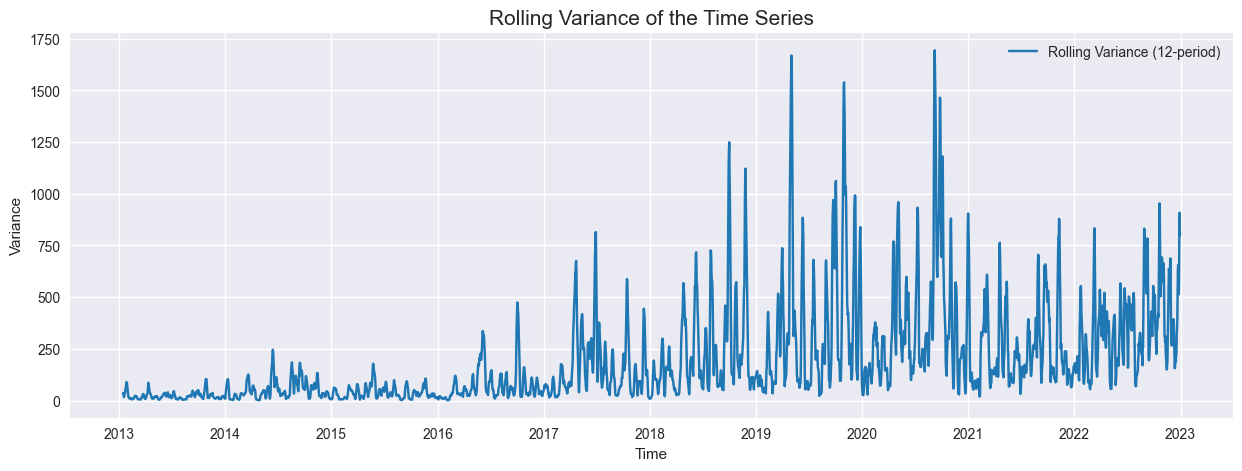

In [7]:
rolling_variance = df['Price'].rolling(window=15).var()

# Plotting the rolling variance
plt.figure(figsize=(15, 5))
plt.plot(rolling_variance, label='Rolling Variance (12-period)', color=color_pale[0])
plt.title('Rolling Variance of the Time Series', fontsize = 15)
plt.xlabel('Time')
plt.ylabel('Variance')
plt.legend()
plt.show()

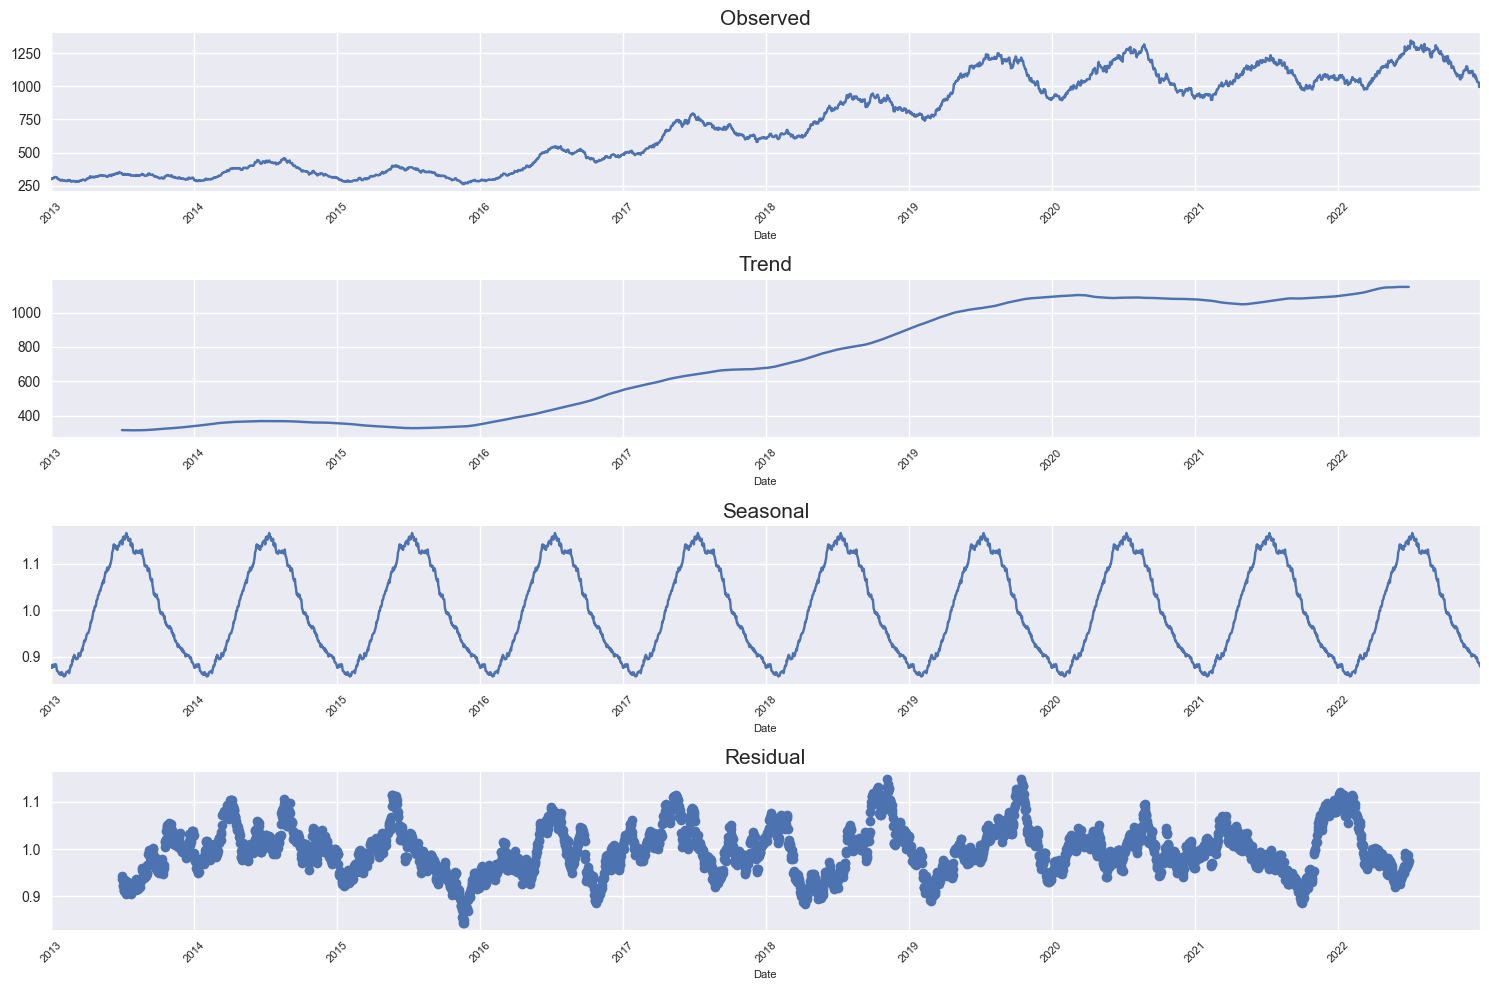

In [8]:
#no data for weekends etc. price from last non-null date is used to fill the data
decomposition_plot_multi = seasonal_decompose(df["Price"], model='multiplicative', period=365)

fig, axes = plt.subplots(4, 1, figsize=(15, 10))  # Adjust figsize for width and height

decomposition_plot_multi.observed.plot(ax=axes[0])
axes[0].set_title('Observed', fontsize = 15)
axes[0].set_xlabel("Date", fontsize = 8)
axes[0].tick_params(axis='x', rotation=45, labelsize=8) # Rotate x-axis ticks if needed

decomposition_plot_multi.trend.plot(ax=axes[1])
axes[1].set_title('Trend', fontsize = 15)
axes[1].set_xlabel("Date", fontsize = 8)
axes[1].tick_params(axis='x', rotation=45, labelsize=8) # Rotate x-axis ticks if needed

decomposition_plot_multi.seasonal.plot(ax=axes[2])
axes[2].set_title('Seasonal', fontsize = 15)
axes[2].set_xlabel("Date", fontsize = 8)
axes[2].tick_params(axis='x', rotation=45, labelsize=8) # Rotate x-axis ticks if needed

decomposition_plot_multi.resid.plot(ax=axes[3], linestyle='None', marker = 'o')
axes[3].set_title('Residual', fontsize = 15)
axes[3].set_xlabel("Date", fontsize = 8)
axes[3].tick_params(axis='x', rotation=45, labelsize=8) # Rotate x-axis ticks if needed


plt.tight_layout() # Important: Adjusts subplot params for a tight layout
plt.show()

### 2. Applaying feature engineering

In [9]:
def create_features(df):   
    """
    Create additional features from the date index
    """
    df["dayofweek"] = df.index.day_of_week.astype(int)
    df["dayofyear"] = df.index.day_of_year.astype(int)
    df["dayofmonth"] = df.index.day
    df["month"] = df.index.month.astype(int)
    df["quarter"] = df.index.quarter.astype(int)
    df["year"] = df.index.year.astype(int)
    df["weekofyear"] = df.index.isocalendar().week

    return df

df = create_features(df)

In [10]:
df

,Price,dayofweek,dayofyear,dayofmonth,month,quarter,year,weekofyear
Date,,,,,,,,
2012-12-31,300.000000,0,366,31,12,4,2012,1
2013-01-01,299.553248,1,1,1,1,1,2013,1
2013-01-02,302.043389,2,2,2,1,1,2013,1
2013-01-03,307.849084,3,3,3,1,1,2013,1
2013-01-04,307.091766,4,4,4,1,1,2013,1
...,...,...,...,...,...,...,...,...
2022-12-26,1030.524458,0,360,26,12,4,2022,52
2022-12-27,1022.667013,1,361,27,12,4,2022,52
2022-12-28,994.676194,2,362,28,12,4,2022,52


### 2.1 Creating Lag features
Identifying the target variable x days in the past

In [11]:
def creating_lags(df, n_lags=4, step=10, start=5):
    """
    Create n lagged features with a specified step and starting point.
    
    Parameters:
        df (pd.DataFrame): The original DataFrame with a datetime index and a 'Price' column.
        n_lags (int): Number of lagged features to create.
        step (int): The step size between each lag (e.g., 10 days).
        start (int): The starting lag (e.g., 30 days).
    
    Returns:
        pd.DataFrame: The DataFrame with added lagged features.
    """
    price_target = df["Price"].to_dict()
    
    for i in range(n_lags):
        lag = start + (i * step)
        df[f"lag_{lag}"] = (df.index - pd.Timedelta(days=lag)).map(price_target)

    # Fill NaN values with 0
    df.fillna(0, inplace=True)
    
    return df

df = creating_lags(df)
df

,Price,dayofweek,dayofyear,dayofmonth,month,quarter,year,weekofyear,lag_5,lag_15,lag_25,lag_35
Date,,,,,,,,,,,,
2012-12-31,300.000000,0,366,31,12,4,2012,1,0.000000,0.000000,0.000000,0.000000
2013-01-01,299.553248,1,1,1,1,1,2013,1,0.000000,0.000000,0.000000,0.000000
2013-01-02,302.043389,2,2,2,1,1,2013,1,0.000000,0.000000,0.000000,0.000000
2013-01-03,307.849084,3,3,3,1,1,2013,1,0.000000,0.000000,0.000000,0.000000
2013-01-04,307.091766,4,4,4,1,1,2013,1,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,1030.524458,0,360,26,12,4,2022,52,1057.390125,1115.661244,1101.750808,1120.258993
2022-12-27,1022.667013,1,361,27,12,4,2022,52,1041.444074,1083.613398,1099.449271,1123.664120
2022-12-28,994.676194,2,362,28,12,4,2022,52,1033.101338,1074.562481,1099.449271,1120.990001


### 3. Visualize feature/target relationship

C:\Users\matte\AppData\Local\Temp\ipykernel_18372\327078365.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\matte\AppData\Local\Temp\ipykernel_18372\327078365.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\matte\AppData\Local\Temp\ipykernel_18372\327078365.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


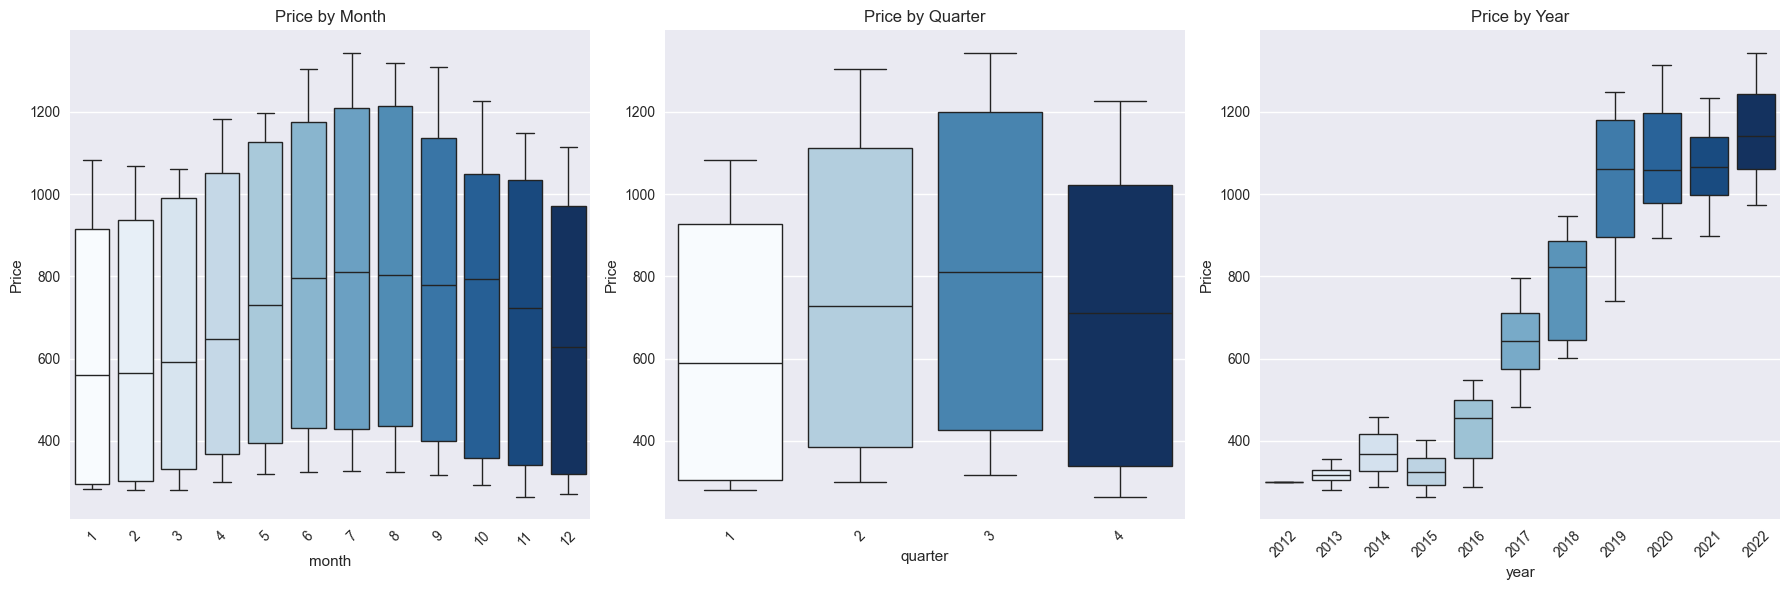

In [12]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Boxplot by Month ---
sns.boxplot(data=df, x="month", y="Price", ax=axes[0], hue = "month", legend= False, palette="Blues")
axes[0].set_title("Price by Month")

# Boxplot by Quarter ---
sns.boxplot(data=df, x="quarter", y="Price", ax=axes[1], hue = "quarter", legend= False, palette="Blues")
axes[1].set_title("Price by Quarter")

# Boxplot by Year ---
sns.boxplot(data=df, x="year", y="Price", ax=axes[2], hue = "year", legend= False, palette="Blues")
axes[2].set_title("Price by Year")

for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

### 4. Train test split

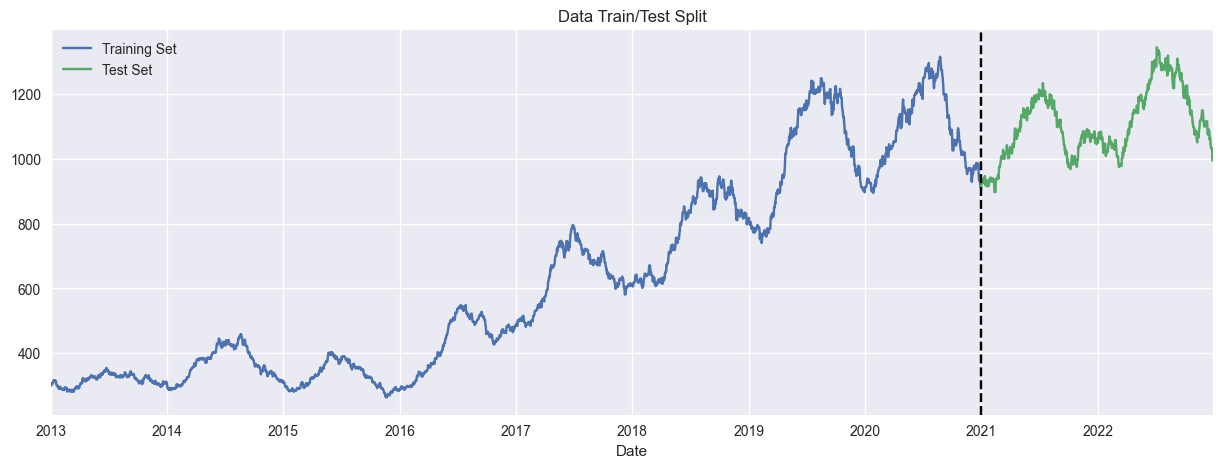

Length of the training set 2921
Length of the test set 731


In [13]:
#get the date to split between training and test set
df_copy = df.copy()
df_copy = df_copy.reset_index()
split_index = int(len(df_copy) * 0.8)

date_index = df_copy.iloc[split_index]["Date"]
df_copy = df_copy.set_index("Date")


# Split the data based on the index
train = df.iloc[:split_index]
test = df.iloc[split_index:]

# Create a plot
fig, ax = plt.subplots(figsize=(15, 5))

# Plot both training and testing data (assume you want to plot the entire dataframe)
train["Price"].plot(ax=ax, label='Training Set')
test["Price"].plot(ax=ax, label='Test Set')

# Add vertical line at the split point
ax.axvline(pd.to_datetime(df.index[df.index==date_index]), color='black', ls='--')

# Add legend and title
ax.legend(['Training Set', 'Test Set'])
ax.set_title('Data Train/Test Split')

# Show the plot
plt.show()

print("Length of the training set", len(train))
print("Length of the test set", len(test))

### 4.1 Training the model with one split

In [14]:
def creating_train_test_sets(df_copy, train, test):    
    features = df_copy.columns.to_list()
    features.remove("Price")
    target = "Price"

    #setting up training
    X_train = train[features]
    y_train = train[target]

    #setting up test
    X_test = test[features]
    y_test = test[target]
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = creating_train_test_sets(df_copy, train=train, test=test)

def training_model_and_getting_predictions(X_train, y_train, X_test, y_test):

    """
    Training the model and returning prediciton and model object
    """

    #setting up model
    reg_model = xgb.XGBRegressor(base_score=0.5, booster='gbtree',   
                            n_estimators=500,
                            early_stopping_rounds=100,
                            objective='reg:squarederror',
                            max_depth=3,
                            learning_rate=0.1)

    reg_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)
    y_pred = reg_model.predict(X_test)
    return y_pred, reg_model

y_pred, model = training_model_and_getting_predictions(X_train, y_train, X_test, y_test)

# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)
score = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {score}")


[0]	validation_0-rmse:624.83827	validation_1-rmse:1001.39901


[100]	validation_0-rmse:12.38846	validation_1-rmse:26.83031
[186]	validation_0-rmse:10.73179	validation_1-rmse:27.19344
Mean Squared Error: 713.4324
Root Mean Squared Error: 26.710154990977706


C:\Users\matte\AppData\Local\Temp\ipykernel_18372\1167674002.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


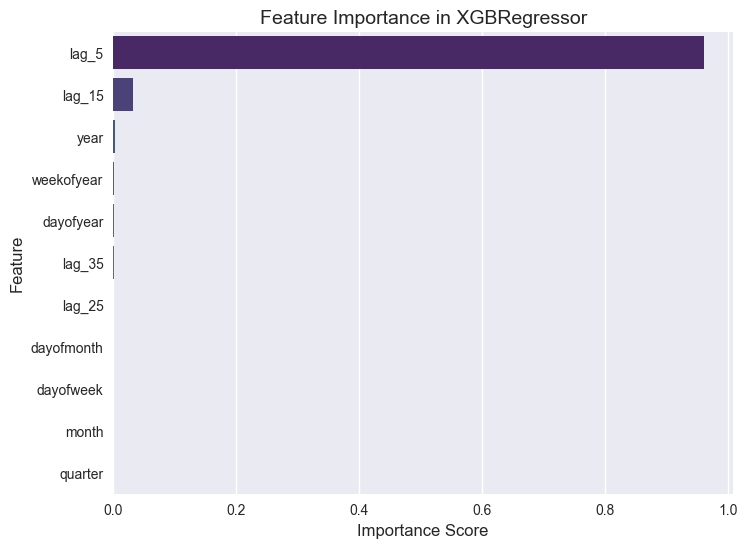

In [15]:
importance_values = model.feature_importances_

# Create a DataFrame to display feature names and their importance scores
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,  # Feature names
    'Importance': importance_values  # Corresponding importance scores
})

# Sort by importance (descending)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(8, 6))

# Create a horizontal bar plot
sns.barplot(
    x=feature_importance_df["Importance"], 
    y=feature_importance_df["Feature"], 
    palette="viridis"
)

# Add title and labels
plt.title("Feature Importance in XGBRegressor", fontsize=14)
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Feature", fontsize=12)

# Show the plot
plt.show()



C:\Users\matte\AppData\Local\Temp\ipykernel_18372\562165104.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["prediction_one_split"] = y_pred


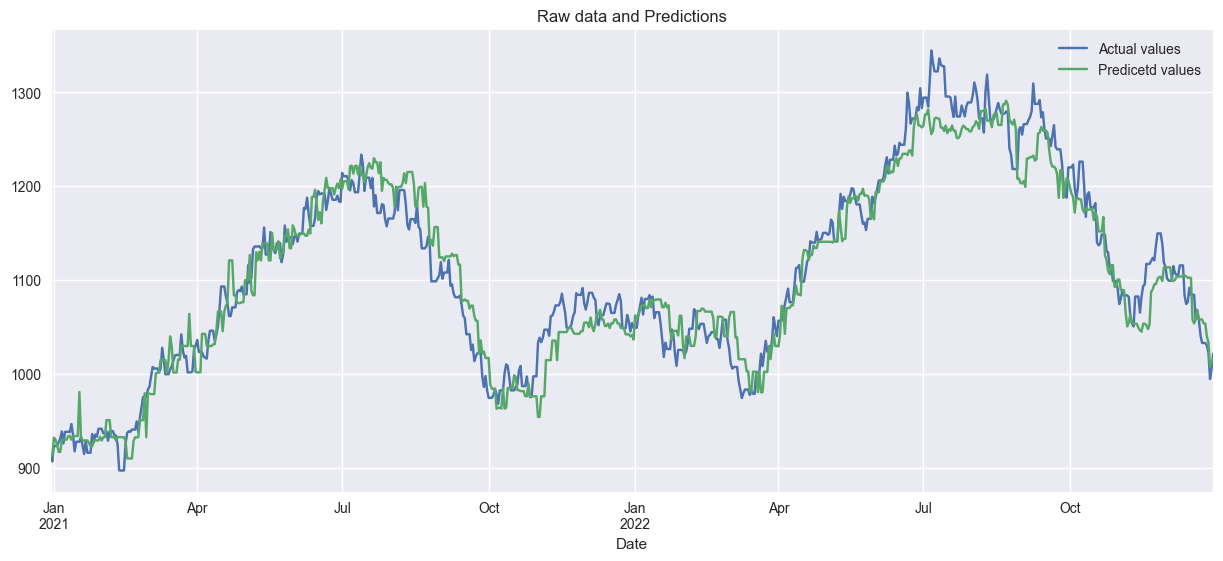

In [16]:
test["prediction_one_split"] = y_pred

ax = test["Price"].plot(figsize=(15, 6))
test["prediction_one_split"].plot(ax=ax)
plt.legend(["Actual values", "Predicetd values"])
plt.title("Raw data and Predictions")
plt.show()

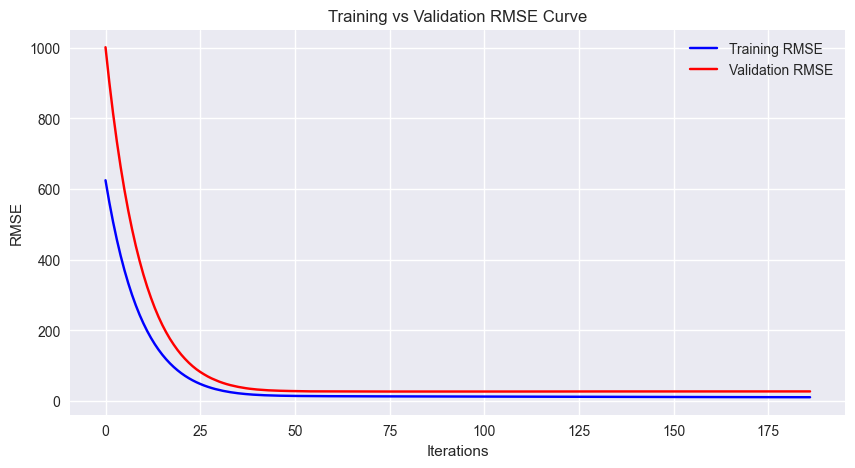

In [17]:
results = model.evals_result_
plt.figure(figsize=(10, 5))
plt.plot(results['validation_0']['rmse'], label="Training RMSE", color='blue')
plt.plot(results['validation_1']['rmse'], label="Validation RMSE", color='red')
plt.xlabel("Iterations")
plt.ylabel("RMSE")
plt.title("Training vs Validation RMSE Curve")
plt.legend()
plt.show()

### 4.2 Training the model with cross validation split

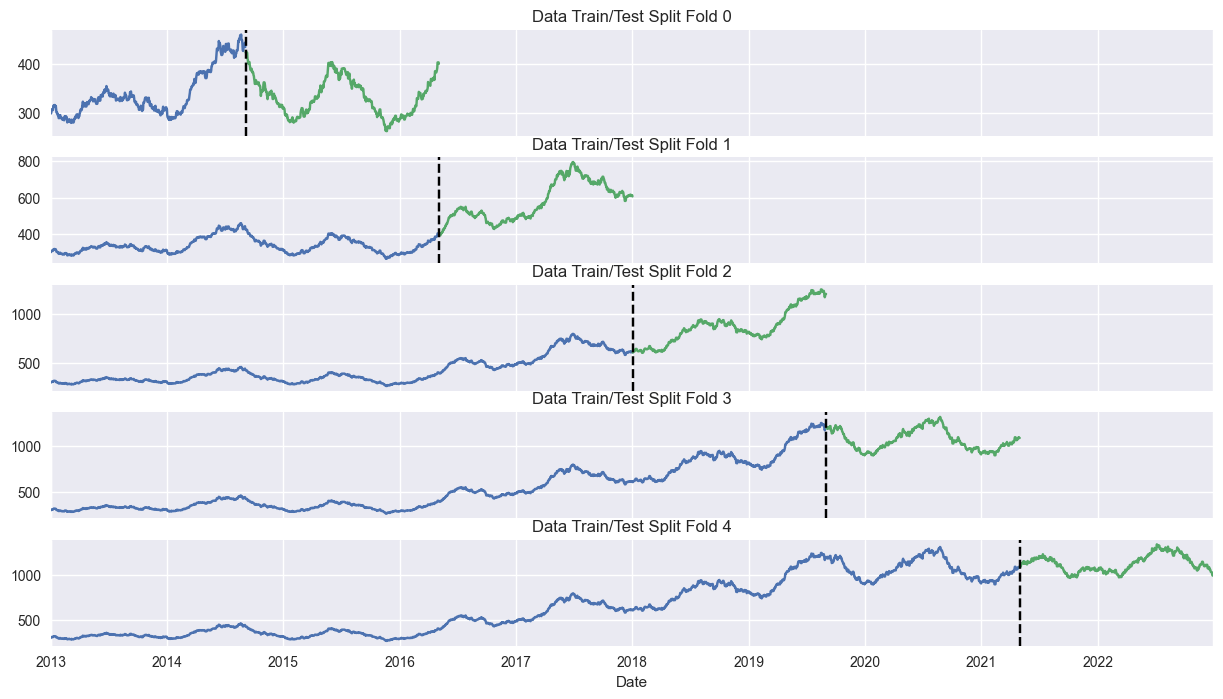

In [ ]:
tss = TimeSeriesSplit(n_splits=5)

fig, axs = plt.subplots(tss.n_splits, 1, figsize = (15, 8), sharex= True)
fold = 0
for train_idx, val_idx in tss.split(df_copy):
    train = df_copy.iloc[train_idx]
    test = df_copy.iloc[val_idx]
    train['Price'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['Price'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [ ]:
preds = []
scores = []
for train_idx, val_idx in tss.split(df_copy):
    train = df_copy.iloc[train_idx]
    test = df_copy.iloc[val_idx]
    
    X_train, X_test, y_train, y_test = creating_train_test_sets(df_copy, train=train, test=test)
    y_pred, model = training_model_and_getting_predictions(X_train, y_train, X_test, y_test)
    
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:339.71105	validation_1-rmse:331.52516
[100]	validation_0-rmse:125.45355	validation_1-rmse:119.11459
[200]	validation_0-rmse:46.57229	validation_1-rmse:42.20617
[300]	validation_0-rmse:17.73685	validation_1-rmse:15.63849
[400]	validation_0-rmse:7.56368	validation_1-rmse:8.75536
[500]	validation_0-rmse:4.46802	validation_1-rmse:8.40970
[561]	validation_0-rmse:3.88705	validation_1-rmse:8.68610
[0]	validation_0-rmse:335.69296	validation_1-rmse:582.10653
[100]	validation_0-rmse:123.61911	validation_1-rmse:324.55675
[200]	validation_0-rmse:45.77257	validation_1-rmse:229.79775
[300]	validation_0-rmse:17.47733	validation_1-rmse:198.89210
[400]	validation_0-rmse:7.74375	validation_1-rmse:185.33145
[500]	validation_0-rmse:5.00314	validation_1-rmse:179.42466
[600]	validation_0-rmse:4.38272	validation_1-rmse:177.45055
[700]	validation_0-rmse:4.19487	validation_1-rmse:176.50726
[800]	validation_0-rmse:4.09945	validation_1-rmse:175.91748
[900]	validation_0-rmse:4.01817	validati

In [ ]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 87.9587
Fold scores:[np.float64(8.25801639261392), np.float64(175.82031905585123), np.float64(193.26635629621714), np.float64(43.355470090052776), np.float64(19.093457827838648)]
